<a href="https://colab.research.google.com/github/OumGhaith/Classification-of-Surface-Defects-in-Steel-Sheets-Using-Developed-NasNet-Mobile-CNN-and-Few-Samples/blob/main/DenseNet_Steel_Inspection_Comparative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Train images: 1440, Val images: 360
Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 180MB/s]


Epoch 1 — Train Loss: 0.2982, Val Loss: 0.0183
Epoch 2 — Train Loss: 0.0544, Val Loss: 0.0115
Epoch 3 — Train Loss: 0.0367, Val Loss: 0.0036
Epoch 4 — Train Loss: 0.0182, Val Loss: 0.0245
Epoch 5 — Train Loss: 0.0365, Val Loss: 0.0027
Epoch 6 — Train Loss: 0.0215, Val Loss: 0.0021
Epoch 7 — Train Loss: 0.0158, Val Loss: 0.0016
Epoch 8 — Train Loss: 0.0079, Val Loss: 0.0010
Epoch 9 — Train Loss: 0.0092, Val Loss: 0.0014
Epoch 10 — Train Loss: 0.0048, Val Loss: 0.0008
Epoch 11 — Train Loss: 0.0069, Val Loss: 0.0012
Epoch 12 — Train Loss: 0.0086, Val Loss: 0.0007
Epoch 13 — Train Loss: 0.0064, Val Loss: 0.0006
Epoch 14 — Train Loss: 0.0038, Val Loss: 0.0031
Epoch 15 — Train Loss: 0.0028, Val Loss: 0.0021
Epoch 16 — Train Loss: 0.0021, Val Loss: 0.0003
Epoch 17 — Train Loss: 0.0024, Val Loss: 0.0005
Epoch 18 — Train Loss: 0.0037, Val Loss: 0.0004
Epoch 19 — Train Loss: 0.0030, Val Loss: 0.0002
Epoch 20 — Train Loss: 0.0097, Val Loss: 0.0018
=== DenseNet121 Performance ===
Accuracy: 100.00%

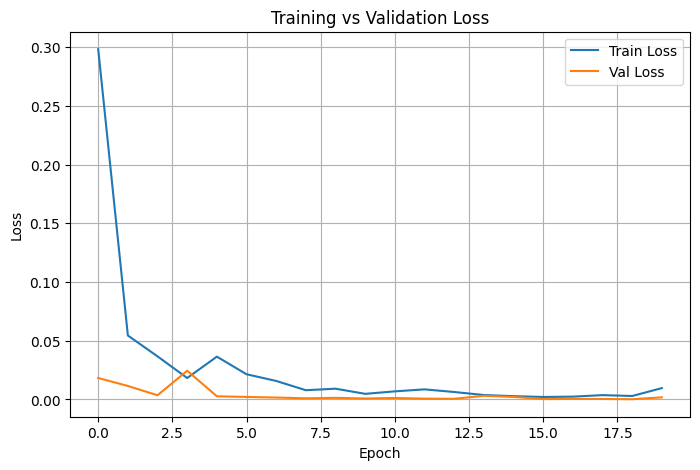

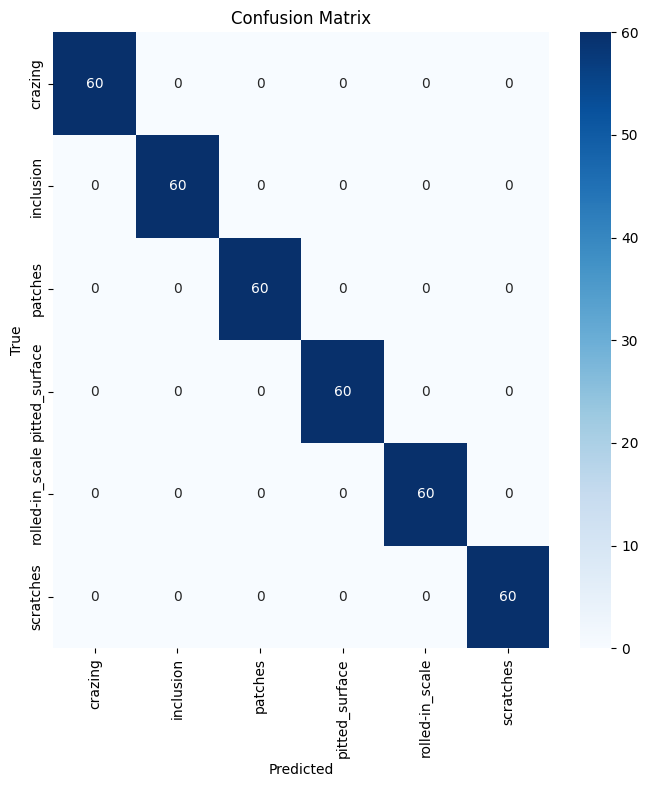

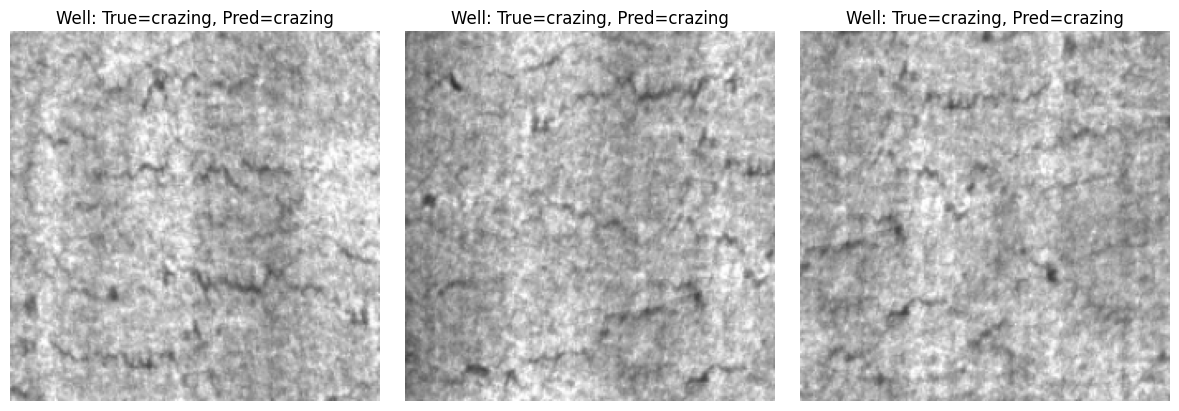

Total Params: 6960006, Trainable: 6960006, Model Size: 28.45 MB, Avg Inference: 19.50 ms


In [ ]:
# =============================
# 1️⃣ Import Required Libraries with no k-cross validation
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
import random
import os
import time

# =============================
# 2️⃣ Set Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# 3️⃣ Define Data Transformations
# =============================
transform = transforms.Compose([
    transforms.Resize((224,224)),       # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # Normalize
])

# =============================
# 4️⃣ Load Dataset
# =============================
train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
val_dataset   = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset',  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)

print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")
print("Classes:", train_dataset.classes)

# =============================
# 5️⃣ Load DenseNet121 Pretrained Model
# =============================
model = models.densenet121(pretrained=True)  # Load ImageNet weights

# Replace classifier for 6 defect classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(train_dataset.classes))

# Send model to GPU
model = model.to(device)

# =============================
# 6️⃣ Define Loss & Optimizer
# =============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# =============================
# 7️⃣ Train the Model
# =============================
epochs = 20
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# =============================
# 8️⃣ Evaluate Model
# =============================
model.eval()
all_true, all_pred, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_true = np.array(all_true)
all_pred = np.array(all_pred)
all_probs = np.array(all_probs)

# Accuracy & Macro Metrics
acc = accuracy_score(all_true, all_pred)*100
precision_macro = precision_score(all_true, all_pred, average='macro')*100
recall_macro = recall_score(all_true, all_pred, average='macro')*100
f1_macro = f1_score(all_true, all_pred, average='macro')*100
report = classification_report(all_true, all_pred, digits=4)
cm = confusion_matrix(all_true, all_pred)

# ROC-AUC
try:
    ohe_true = np.eye(len(train_dataset.classes))[all_true]
    auc_score = roc_auc_score(ohe_true, all_probs, multi_class='ovr')*100
except:
    auc_score = None

print("=== DenseNet121 Performance ===")
print(f"Accuracy: {acc:.2f}% | Macro Precision: {precision_macro:.2f}% | Macro Recall: {recall_macro:.2f}% | Macro F1: {f1_macro:.2f}% | ROC-AUC: {auc_score if auc_score else 'N/A'}%")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# =============================
# 9️⃣ Plot Loss Curves
# =============================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# =============================
# 10️⃣ Plot Confusion Matrix Heatmap
# =============================
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =============================
# 11️⃣ Plot Sample Well & Misclassified Images
# =============================
# Well-classified
wellclassified = [(img, t, torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item())
                  for img, t in val_dataset if torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item() == t]

# Misclassified
misclassified = [(img, t, torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item())
                  for img, t in val_dataset if torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).item() != t]

fig = plt.figure(figsize=(12,8))
for i in range(min(3, len(wellclassified))):
    img, t, p = wellclassified[i]
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5+0.5)
    ax.set_title(f"Well: True={train_dataset.classes[t]}, Pred={train_dataset.classes[p]}")
    ax.axis('off')

for i in range(min(3, len(misclassified))):
    img, t, p = misclassified[i]
    ax = fig.add_subplot(2,3,i+4)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5+0.5)
    ax.set_title(f"Mis: True={train_dataset.classes[t]}, Pred={train_dataset.classes[p]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# =============================
# 12️⃣ Compute Efficiency Metrics
# =============================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
torch.save(model.state_dict(), '/content/drive/MyDrive/steel_images/densenet121_model.pt')
model_size_mb = os.path.getsize('/content/drive/MyDrive/steel_images/densenet121_model.pt') / 1e6

# Average inference time per image
start_time = time.time()
_ = model(torch.randn(1,3,224,224).to(device))
inference_time = (time.time() - start_time) * 1000  # ms

print(f"Total Params: {total_params}, Trainable: {trainable_params}, Model Size: {model_size_mb:.2f} MB, Avg Inference: {inference_time:.2f} ms")


In [3]:
# ===================================
=
# 1️⃣ Import Libraries with k-cross validation
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os

# =============================
# 2️⃣ Set Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# 3️⃣ Define Transformations
# =============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# =============================
# 4️⃣ Load Full Dataset (Train + Test)
# =============================
train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
test_dataset  = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)

# Combine datasets
all_dataset = train_dataset + test_dataset
all_labels = np.array([label for _, label in all_dataset])

# =============================
# 5️⃣ Set up Stratified K-Fold
# =============================
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# =============================
# 6️⃣ Cross-Validation Loop
# =============================
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):
    print(f"\n=== Fold {fold+1}/{k_folds} ===")

    train_subset = Subset(all_dataset, train_idx)
    val_subset   = Subset(all_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=16, shuffle=False)

    # 6a️⃣ Load DenseNet121
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, len(train_dataset.classes))
    model = model.to(device)

    # 6b️⃣ Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 6c️⃣ Train
    epochs = 10  # reduce for testing
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 6d️⃣ Evaluate
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    acc = (np.array(all_true) == np.array(all_pred)).mean()*100
    print(f"Fold {fold+1} Accuracy: {acc:.2f}%")
    fold_results.append(acc)

print(f"\n=== Cross-Validation Results ===")
print(f"Mean Accuracy: {np.mean(fold_results):.2f}% | Std: {np.std(fold_results):.2f}%")


Using device: cuda

=== Fold 1/5 ===
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 162MB/s] 


Fold 1 Accuracy: 100.00%

=== Fold 2/5 ===
Fold 2 Accuracy: 99.72%

=== Fold 3/5 ===
Fold 3 Accuracy: 100.00%

=== Fold 4/5 ===
Fold 4 Accuracy: 100.00%

=== Fold 5/5 ===
Fold 5 Accuracy: 100.00%

=== Cross-Validation Results ===
Mean Accuracy: 99.94% | Std: 0.11%
